In [1]:
#  Organize the data in a way suitable to use for statistics.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import nan

# ------ LOAD data-tables ---------------------------------------------------- 
# List of clinical table with features and timepoints
path_Klinisk  = "/Users/mattesa/molbreastlab-storage/work/Radiation_study/Matteo/ClinicalData_Klinisk.csv" 
path_Oversikt = "/Users/mattesa/molbreastlab-storage/work/Radiation_study/Matteo/ClinicalData_Oversikt.csv" 
path_Lipopro  = "/Users/mattesa/molbreastlab-storage/work/Radiation_study/Matteo/Lipoproteinene_Combined2.csv" 

root_path = os.path.dirname(path_Lipopro)
             
# Load clinical data file: it contains all the metadata on medications, 
# treatments, sample collection timepoints etc...
# Specifically, load the sheets "Oversikt" and "Klinik fra Randi"
CD_klinisk = pd.read_csv( path_Klinisk,  header=1, index_col=False)
CD_oversik = pd.read_csv( path_Oversikt, header=0, index_col=False)
   
# Load Lipoprotein measurments file: it contains all the measurments for all 
# the blood plasma lipoproteins (only). 
# NOTE: There are some redundant columns
LP_measure = pd.read_csv( path_Lipopro, header=0, index_col=False)


# ------ PRUNING the data ----------------------------------------------------
# Extract the timepoints as defined by Guro, but also the date itself, which 
# can be used to pairs entries in different tables.
#result = pd.merge(left, right, on="key")
sele_oversik  = [ "PatientID", 
                  "Samplenames lipo", "Names date modified", "Samling date", 
                  "Dato stråleterapi", "Timepoint", "Timepoint_kodet" ]
CD_timepoints = CD_oversik.loc[:,sele_oversik]

# Rename column "Samplenames lipo" in CD_oversik === "name" in LP_measure
CD_timepoints = CD_timepoints.rename(columns={"Samplenames lipo": "Samplename"})
LP_measure    = LP_measure.rename(columns={"name": "Samplename"})

# Insert a "PatientID" column in LP_measure dataframe as well (redundant but good practice)
LP_measure.insert( loc=1, column="PatientID", value=CD_timepoints["PatientID"])

# Find missing samples, samples (CD_oversik) that have no measurement (LP_measure)
# Do set-difference to find missing samples, then a second one to remove them 
# from the list, and in turn from the dataframe
miss_nn = np.setdiff1d( CD_timepoints["Samplename"], LP_measure["Samplename"])
list_nn = np.setdiff1d( CD_timepoints["Samplename"], miss_nn )
CD_timepoints = CD_timepoints.loc[CD_timepoints["Samplename"].isin(list_nn)]

# Remove quality control measurments: string value starting with "QC"
mask_QC = ["QC" not in xx   for xx in LP_measure["Samplename"]]
LP_measure    = LP_measure.loc[ mask_QC, : ]
CD_timepoints = CD_timepoints.loc[ mask_QC, : ]

# At this point we should have the exact same entries in both DataFrames. 
# We can sort-by name columns "Samplename" and "name" should be
# equivalent in both tables
CD_timepoints = CD_timepoints.sort_values("Samplename")
LP_measure    = LP_measure.sort_values("Samplename")

# Some timepoints are uncategorized, and must be removed
mask = CD_timepoints["Timepoint_kodet"].isnull().values
LP_measure    = LP_measure.loc[ ~mask, : ]
CD_timepoints = CD_timepoints.loc[ ~mask, : ]

# Now that we have same order and have sorted tables, we can reindex both.
# Thus, both are sorted and have same row index
LP_measure = LP_measure.reset_index(drop=True)
CD_timepoints = CD_timepoints.reset_index(drop=True)

# ------ SAVE ----------------------------------------------------------------
# Save as Python-Ready .csv file
LP_measure.to_csv(    root_path + "/PyR_Lipoproteine.csv", header=True, index=True)
CD_timepoints.to_csv( root_path + "/PyR_Timepoints.csv"  , header=True, index=True)

Outer-loop:  1


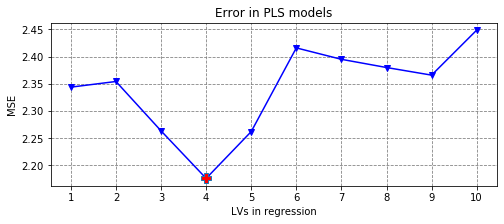

Outer-loop:  2


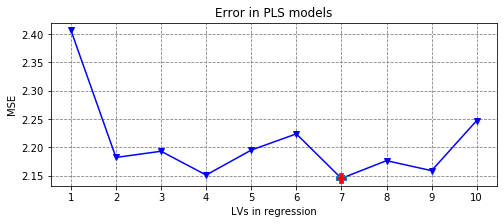

Outer-loop:  3


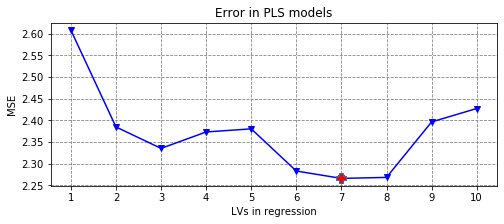

Outer-loop:  4


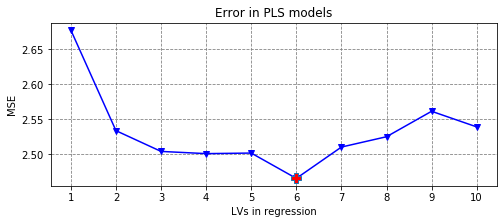

Outer-loop:  5


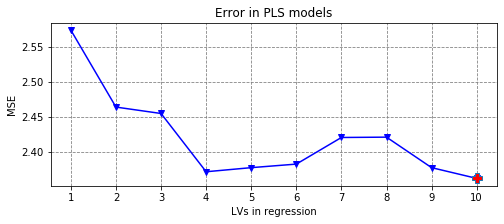

Outer-loop:  6


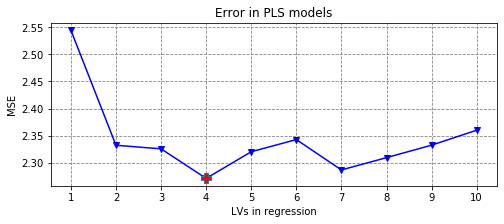

,o1,o2,o3,o4,o5,o6
Suggested_N_comp,3.000000,6.000000,6.0000,5.000000,9.000000,3.000000
Accuracy,0.823529,0.866667,0.8625,0.863014,0.884615,0.869048


In [207]:
import sys
# Add as desired to the list of known working paths for Python 
sys.path.append('F:/Python/')

import mbc_PLS_basic
from mbc_PLS_basic import *
# Force reload during development, otherwise Python only loads first time 
# and does not update unless the kernel is rebooted
#import importlib
#importlib.reload(mbc_PLS_basic)


# --- 0 --- Parameters for the cross validation ------------------------------
max_N_comp = 10           # Maximum number of components to tes
outer_PropSele = 0.2      # proportion train-to-test to use
inner_PropSele = 0.2    
outer_loop  = 6           # cycles number to perform double cross val.
inner_loop  = 3
p_threshold = 3           # predicted probability threshold
min_cat  = 1
max_cat = 5

# Column name for the response variable to use in PLS-DA
unique_PatientID_Col = "PatientID"
Response_Col         = "Timepoint_kodet"


# --- 1 --- Prepare the DataFrames in the appropriate format -----------------
# Prepare the data we wish to use for the PLS model in XX and YY dataframes.
# Scale-standardize the XX matrix and reduce selection only for data with 
# specific values in "Response_Col" column (min_cat, max_cat)
YY = CD_timepoints.copy()
XX_vars_scaled, XX_scaled = StandardScale_FeatureTable( LP_measure , 4)
XX, YY = CrossSelect_TwoTables( XX_vars_scaled, YY, Response_Col, [min_cat,max_cat] ) 


# --- 2 --- Cross-validation of PLS ------------------------------------------
accuracy, comparPred, outerMSE, innerMSE = optimise_PLS_CrossVal(
                              XX, YY, max_N_comp, unique_PatientID_Col,
                              Response_Col, min_cat, max_cat, p_threshold , 
                              outer_loop, inner_loop, outer_PropSele, inner_PropSele,
                              True)

accuracy

In [ ]:
plot_metrics(outerMSE.iloc[ 0:1, :].T.values, 'MSE', 'min')

(-15, 15)

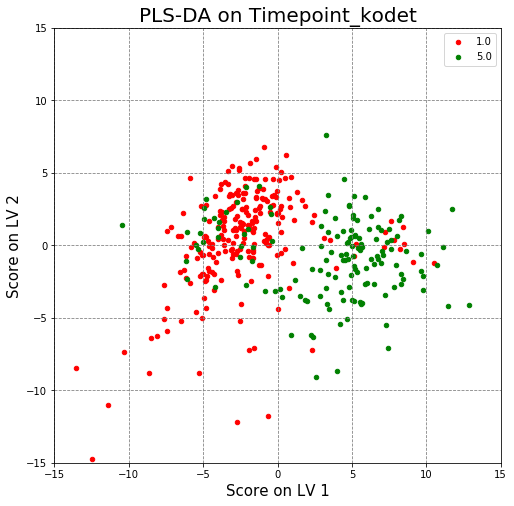

In [208]:

# --- 3 --- Plot PLS by Response_Col --------------------------------------------

PLS_scores = PLS_fit_model( XX, YY.loc[:, Response_Col ], 4, Response_Col)

# We create a 2D scatter plot, we only need to take the first two latent 
# variables and the response column (the last). We color each category 
# (targets) with a unique color
plotDF = PLS_scores.iloc[:,[0,1,-1]]

targets = np.sort( plotDF[Response_Col].unique() )
colors  = ['r', 'g', 'b', 'k', 'm', 'c', 'o']

fig = plt.figure(figsize = (8,8))
ax  = fig.add_subplot(1,1,1) 

# Plot the PCA in as 2D scatterplot and uniquely  color each flowcell data
for target, color in zip(targets,colors):
    ind_xx = plotDF[Response_Col] == target
    ax.scatter( plotDF.loc[ind_xx, 'Score_LV_1'], 
                plotDF.loc[ind_xx, 'Score_LV_2'], 
                c = color,
                s = 20)
ax.set_xlabel('Score on LV 1', fontsize = 15)
ax.set_ylabel('Score on LV 2', fontsize = 15)
ax.set_title('PLS-DA on '+ Response_Col , fontsize = 20)
ax.legend(targets)
plt.grid(color = "grey", linestyle='--')
nn = 15
ax.set_xlim([-nn, nn])
ax.set_ylim([-nn, nn])

# --- SAVE the plot ----------------------------------------------------------
# plt.savefig("PLS-DA_Timepoint_"+region+".svg")

In [144]:
innerMSE

,lv1,lv2,lv3,lv4,lv5,lv6,lv7,lv8,lv9,lv10,lv11,lv12,lv13,lv14,lv15,lv16,lv17,lv18,lv19,lv20
i1,2.168892,2.038056,1.897941,1.993413,1.997811,1.979025,2.254908,2.202110,2.280438,2.369870,2.349112,2.316186,2.293044,2.184996,2.125124,2.108810,2.237035,2.426691,2.287719,2.348508
i2,2.297023,2.237248,2.304814,2.437346,2.394342,2.300359,2.314936,2.276475,2.257996,2.245367,2.255812,2.266699,2.274538,2.215586,2.331833,2.420454,2.375936,2.442907,2.384413,2.456750
i3,3.199045,3.094268,3.093928,3.068141,3.083239,2.949278,2.802708,2.827490,2.939868,2.919445,2.838085,2.843982,2.859349,2.868276,3.016419,2.961155,3.007926,3.030688,3.052694,3.052848


In [289]:
outerMSE

,lv1,lv2,lv3,lv4,lv5,lv6,lv7,lv8,lv9,lv10
o1,2.253611,2.137724,2.131652,2.144554,2.051769,1.939448,2.044570,1.960789,1.967209,2.008326
o2,2.024844,1.951056,1.933805,1.970503,1.958872,1.962882,2.001039,1.980820,1.944342,1.927154
o3,2.426493,2.320246,2.373791,2.351203,2.414218,2.484418,2.461694,2.414662,2.433805,2.439224
o4,2.124655,2.025984,2.010825,2.012277,2.018440,2.041187,2.073125,2.119635,2.136968,2.107233


In [99]:
comparPred.head(20)

,oY_test,oY_pred,Y_pred_thres,T-F
0,5,2.33246,1,False
1,1,2.37158,1,True
2,5,2.58149,1,False
3,1,2.67006,1,True
4,5,0.613014,1,False
5,1,1.70392,1,True
6,1,2.27101,1,True
7,5,1.94467,1,False
8,5,1.06659,1,False
9,1,1.9403,1,True


In [203]:
AA = pd.DataFrame( data = { "C1":[0,1,2,3,4,5,6,7,8,9],
                            "C2":[0,1,2,3,4,5,6,7,8,9],
                            "C3":["0","1","2","3","4","5","6","7","8","9"],
                            "C4":["0","1","2","3","4","5","6","7","8","9"]  
                          } )

BB = pd.DataFrame( data = { "C1":[0,1,2,3,4,5,6,7,8,9],
                            "C2":[0,1,1,3,3,5,5,7,7,0],
                            "C3":["0","1","2","3","4","5","6","7","8","9"],
                            "C4":["2","2","4","4","6","6","7","7","8","8"]  
                           } )

comparison = [ qq == ee for qq,ee in zip( AA["C1"], BB["C2"]) ]

#if   np.all(equality_check):
    # All values between the two columns are equal
    
#elif np.any(equality_check):
    # Only some values between columns are equal


# check uniqueness of lists

train_pID = np.setdiff1d( uID_List, test_pID )
train_idx = np.where( M_Y[uID_colname].isin( train_pID ))[0].tolist()


check_all = np.all(equality_check)
idx = np.where(comparison)[0].tolist()
idx

[0, 1, 3, 5, 7]

In [188]:
comparison 

[True, True, False, True, False, True, False, True, False, False]

In [204]:
YY

,PatientID,Samplename,Names date modified,Samling date,Dato stråleterapi,Timepoint,Timepoint_kodet
0,17196,17196_14.06.07,17196_14.06.2007,14.06.2007,11/07/2007,pre,1.0
4,17547,17547_05.03.08,17547_05.03.2008,05.03.2008,20/03/2007,12 months,5.0
7,17548,17548_03.04.08,17548_03.04.2008,03.04.2008,19/03/2007,12 months,5.0
8,17548,17548_08.03.07,17548_08.03.2007,08.03.2007,19/03/2007,pre,1.0
13,17606,17606_16.05.07,17606_16.05.2007,16.05.2007,21/05/2007,pre,1.0
...,...,...,...,...,...,...,...
979,19943,19943_22.09.2008,19943_22.09.2008,22.09.2008,01/10/2008,pre,1.0
981,19944,19944_03.11.2009,19944_03.11.2009,03.11.2009,01/10/2008,12 months,5.0
984,19944,19944_22.09.2008,19944_22.09.2008,22.09.2008,01/10/2008,pre,1.0
986,19957,19957_26.09.08,19957_26.09.2008,26.09.2008,06/10/2008,pre,1.0


In [205]:
XX

,TPTG [mg/dL],TPCH [mg/dL],LDCH [mg/dL],HDCH [mg/dL],TPA1 [mg/dL],TPA2 [mg/dL],TPAB [mg/dL],LDHD [-/-],ABA1 [-/-],TBPN [nmol/L],...,H3PL [mg/dL],H4PL [mg/dL],H1A1 [mg/dL],H2A1 [mg/dL],H3A1 [mg/dL],H4A1 [mg/dL],H1A2 [mg/dL],H2A2 [mg/dL],H3A2 [mg/dL],H4A2 [mg/dL]
0,-1.021390,0.355946,0.772194,0.875727,0.308342,0.721153,-0.080823,-0.303100,-0.445381,-0.080836,...,0.342627,1.338983,-0.167471,0.207996,-0.399878,1.113636,-0.361733,-0.463724,-0.204302,1.558075
4,-0.562963,-1.034348,-0.905724,-0.415530,-0.691407,-0.842188,-1.106919,-0.517490,-0.691460,-1.106828,...,-0.222810,0.636288,-1.128589,-0.390092,-0.435658,0.300435,-0.988294,-1.035624,-1.206317,0.128014
7,-0.775281,-0.262324,0.113796,0.674396,0.483205,0.533449,-0.333556,-0.565132,-0.773487,-0.333809,...,1.324703,0.975520,0.062813,0.967108,0.932928,0.646116,0.171512,0.507175,0.621535,0.560751
8,-0.874416,-1.005682,-0.734612,-0.421854,-0.978726,-0.883329,-1.082368,-0.374563,-0.363355,-1.082444,...,-0.409872,-0.060348,-0.794357,-0.536739,-0.745752,-0.388094,-0.988294,-0.995724,-1.250362,-0.284438
13,0.520812,-0.759416,-1.750046,-0.907788,-1.096744,-0.952753,-0.961056,-0.839076,-0.117275,-0.961319,...,-0.312090,-0.506600,-0.570469,-0.568369,-0.537035,-0.996343,-0.721672,-0.463724,-0.556659,-0.984255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,1.395527,1.350130,1.314644,-0.640050,-0.306460,0.641443,1.703473,1.554951,2.179464,1.703561,...,-1.510987,-0.837755,-0.479315,-0.763898,-0.784513,-0.238866,-0.001793,0.094875,0.092999,0.496517
981,-0.596551,-1.052590,-0.498631,-1.493861,-1.111573,-1.065890,-0.853464,1.281008,0.046777,-0.853577,...,-1.005069,-0.837755,-1.071018,-1.267097,-1.040937,-0.959508,-0.988294,-1.035624,-0.831938,-0.936925
984,-0.854060,-0.759416,-0.071617,-1.237717,-1.060906,-0.893614,-0.648389,1.257187,0.292857,-0.648219,...,-0.971058,-0.540927,-1.141382,-1.292976,-1.204929,-0.636494,-0.988294,-0.743024,-0.942049,-0.494045
986,-0.636654,0.149096,0.202162,0.030349,0.187235,-0.191653,-0.172529,-0.064888,-0.363355,-0.172176,...,0.057783,0.232441,-0.090710,-0.450476,-0.071895,0.368438,-0.894977,-1.035624,-0.523626,0.117872
